# Análise de Clusterização de Países
## Projeto: Algoritmos de Inteligência Artificial para Clusterização

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
import os
output_dir = 'graficos'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print('Setup completo!')

Setup completo!


In [2]:
df = pd.read_csv('dataset/Country-data.csv')
print(f'Dataset: {df.shape}')
print(f'Países: {len(df)}')
print(df.head())

Dataset: (167, 10)
Países: 167
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [3]:
df_clean = df.dropna()
print(f'Após remover NaN: {df_clean.shape}')
print(f'Número de países: {len(df_clean)}')

Após remover NaN: (167, 10)
Número de países: 167


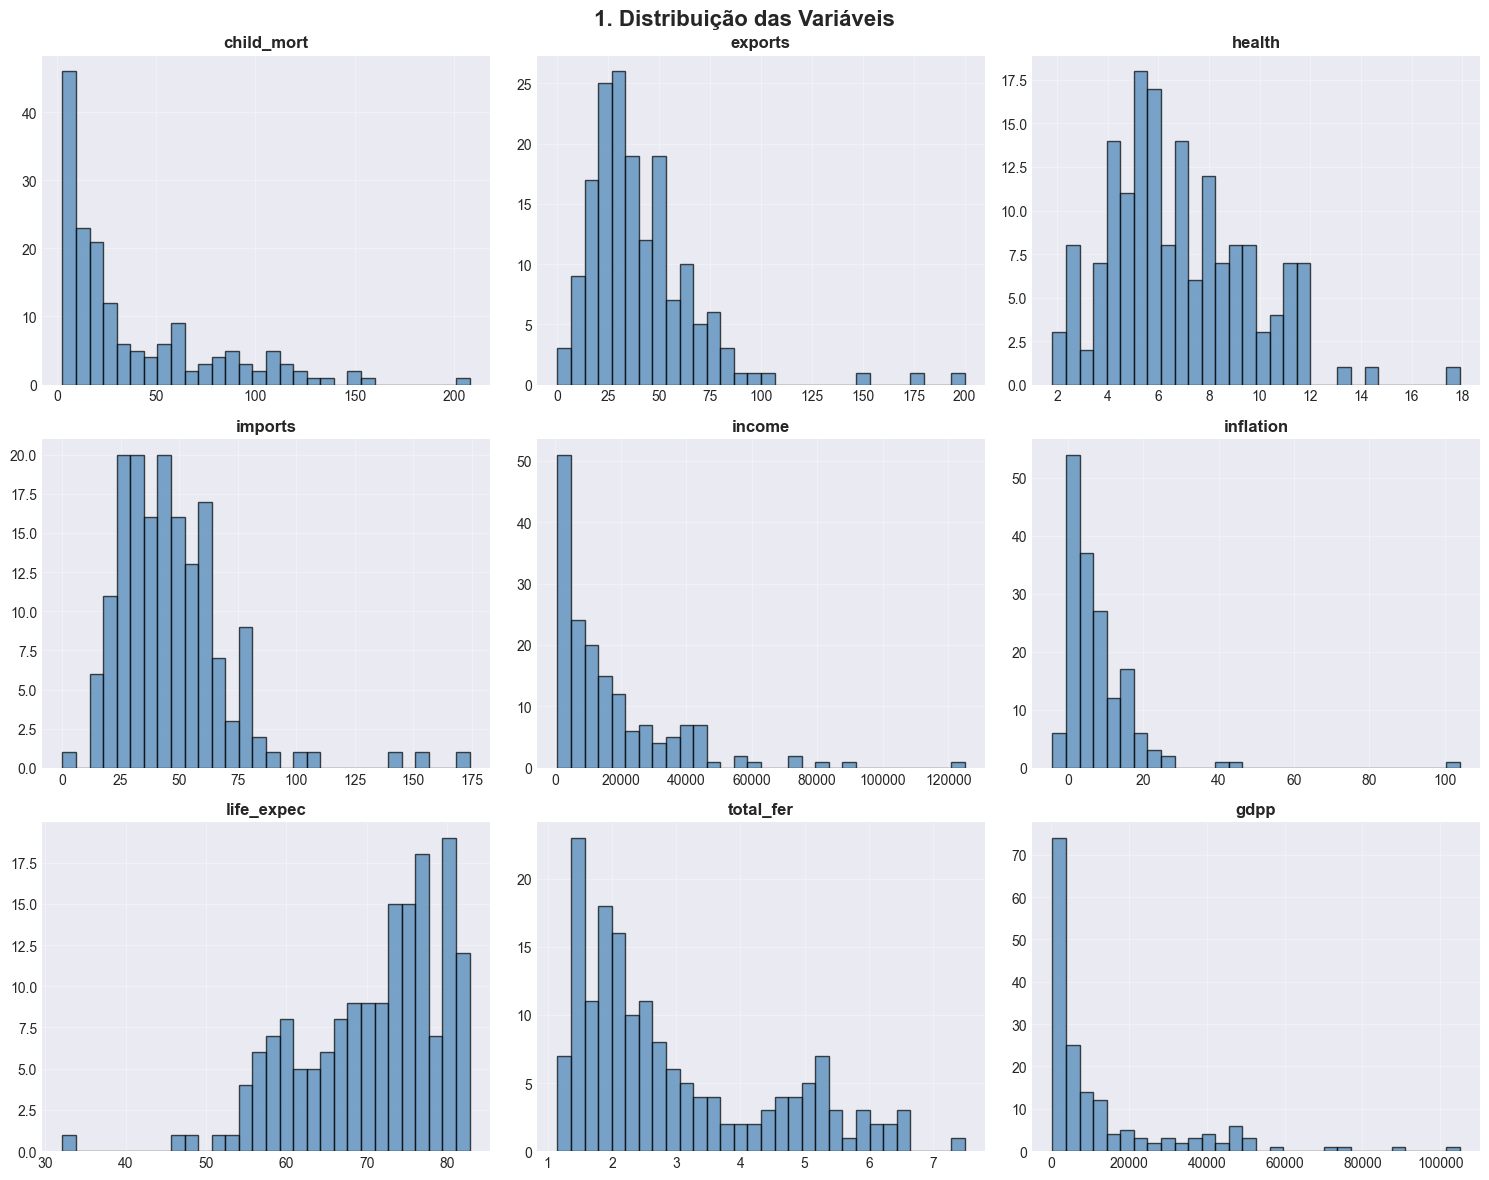

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('1. Distribuição das Variáveis', fontsize=16, fontweight='bold')
features = df_clean.columns[1:]
for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df_clean[feature], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'{feature}', fontweight='bold')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/01_distribuicao_variaveis.png', dpi=300, bbox_inches='tight')
plt.show()

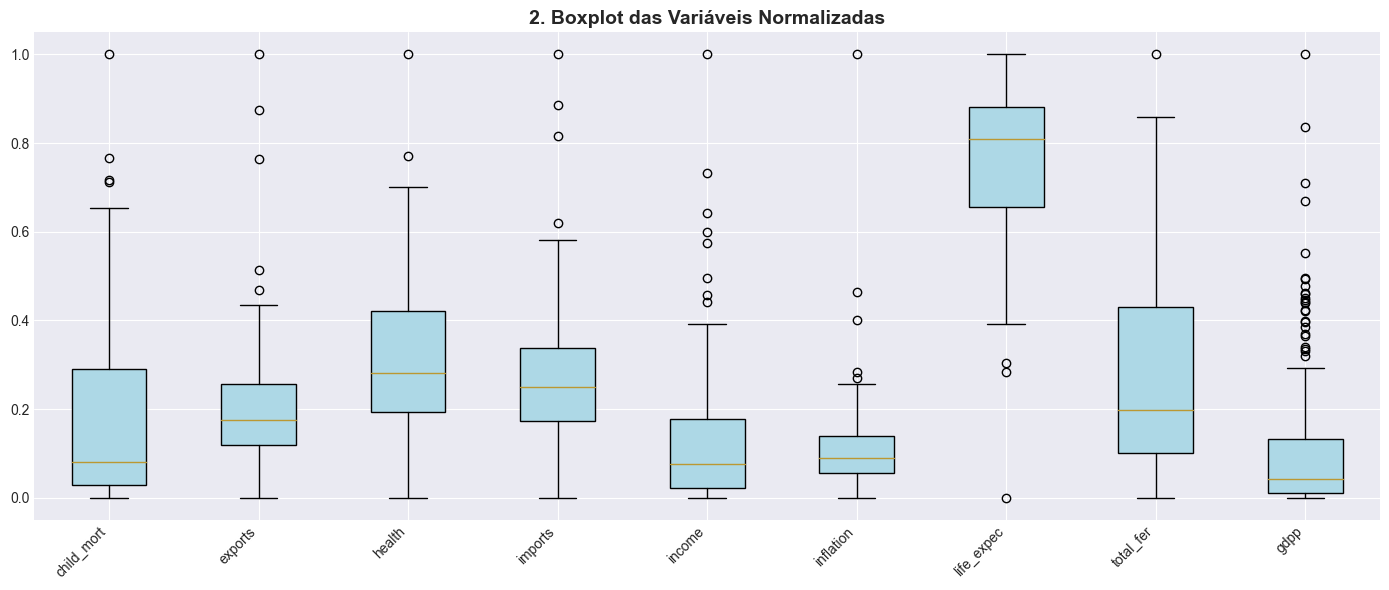

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
df_norm = (df_clean.iloc[:, 1:] - df_clean.iloc[:, 1:].min()) / (df_clean.iloc[:, 1:].max() - df_clean.iloc[:, 1:].min())
bp = ax.boxplot([df_norm[col] for col in df_norm.columns], labels=df_norm.columns, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_title('2. Boxplot das Variáveis Normalizadas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{output_dir}/02_boxplot_variaveis.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
X = df_clean.iloc[:, 1:].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Dados padronizados com sucesso!')
print(f'Forma: {X_scaled.shape}')

Dados padronizados com sucesso!
Forma: (167, 9)


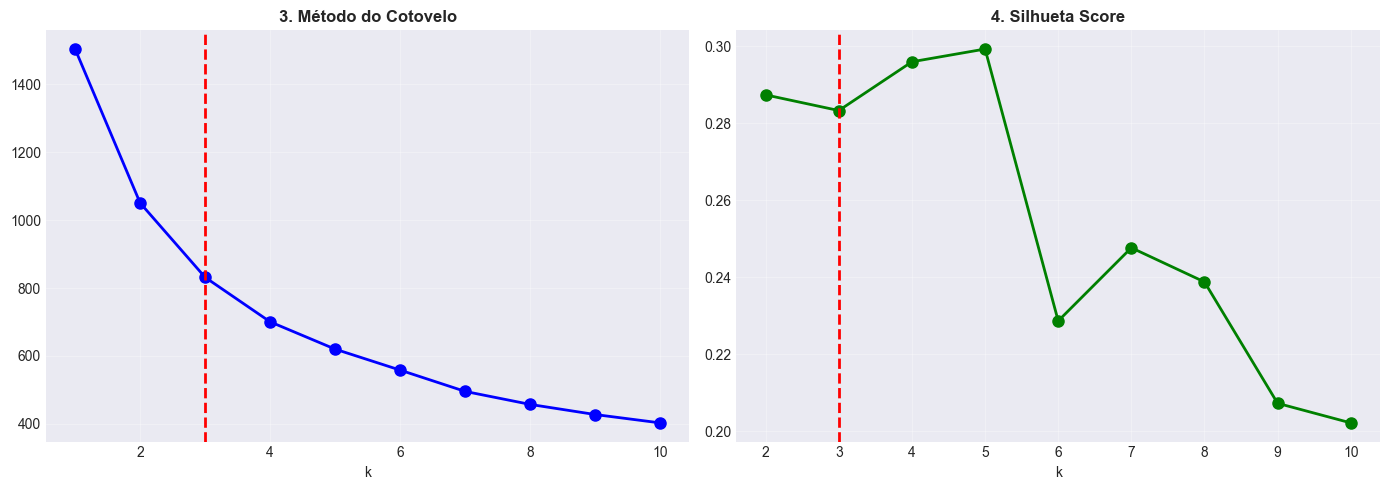

In [7]:
inertias = []
silhouette_scores = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(range(1, 11), inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=3, color='red', linestyle='--', linewidth=2)
ax1.set_title('3. Método do Cotovelo', fontweight='bold')
ax1.set_xlabel('k')
ax1.grid(True, alpha=0.3)
ax2.plot(range(2, 11), silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=3, color='red', linestyle='--', linewidth=2)
ax2.set_title('4. Silhueta Score', fontweight='bold')
ax2.set_xlabel('k')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/03_metodo_cotovelo.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df_clean['KMeans_Cluster'] = kmeans_labels
print('K-Médias com k=3 concluído')
print(df_clean['KMeans_Cluster'].value_counts().sort_index())

K-Médias com k=3 concluído
KMeans_Cluster
0    36
1    47
2    84
Name: count, dtype: int64


In [9]:
for cluster in range(3):
    cluster_data = df_clean[df_clean['KMeans_Cluster'] == cluster]
    print(f'\nCluster {cluster}: {len(cluster_data)} países')
    print(f'Países: {list(cluster_data["country"].values)[:5]}...')
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    distances = np.linalg.norm(X_scaled[cluster_indices] - kmeans.cluster_centers_[cluster], axis=1)
    closest_idx = cluster_indices[np.argmin(distances)]
    print(f'País representativo: {df_clean.iloc[closest_idx]["country"]}')


Cluster 0: 36 países
Países: ['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei']...
País representativo: Iceland

Cluster 1: 47 países
Países: ['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso']...
País representativo: Guinea

Cluster 2: 84 países
Países: ['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia']...
País representativo: Jamaica


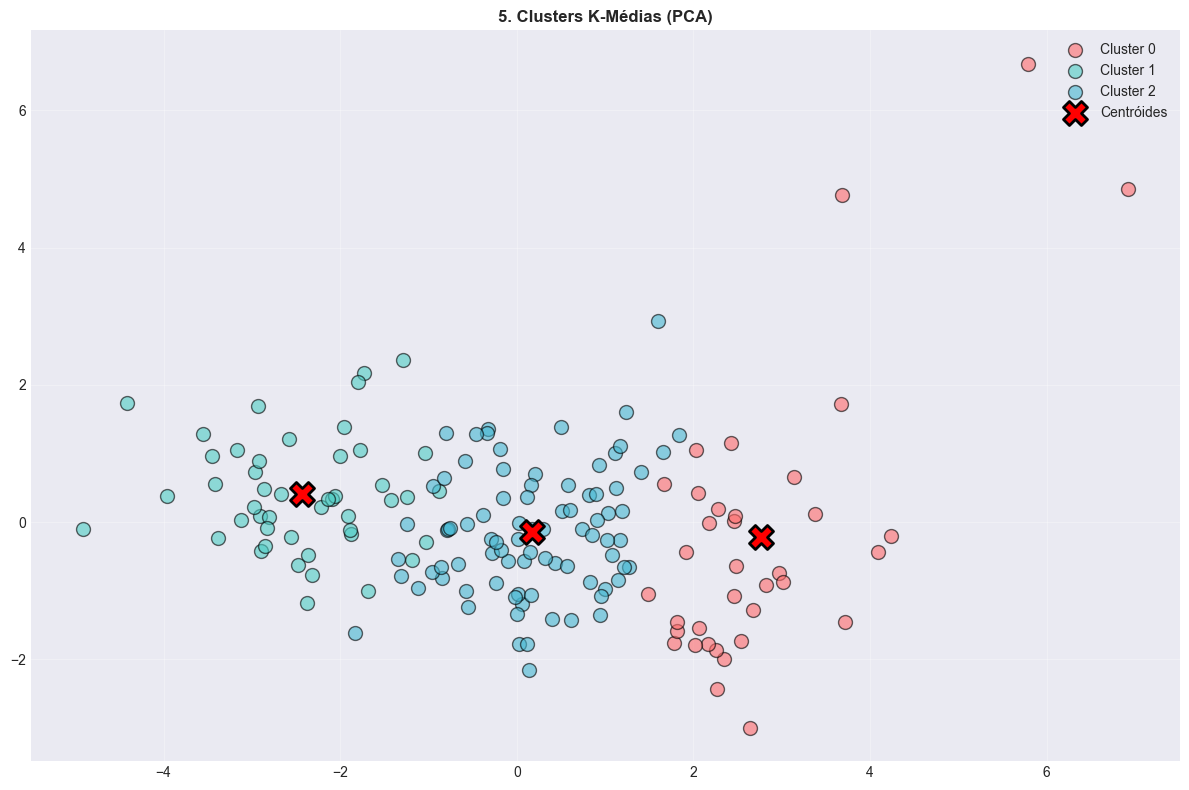

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for cluster in range(3):
    mask = kmeans_labels == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[cluster], label=f'Cluster {cluster}', s=100, alpha=0.6, edgecolors='black')
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centróides')
ax.set_title('5. Clusters K-Médias (PCA)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/04_kmeans_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

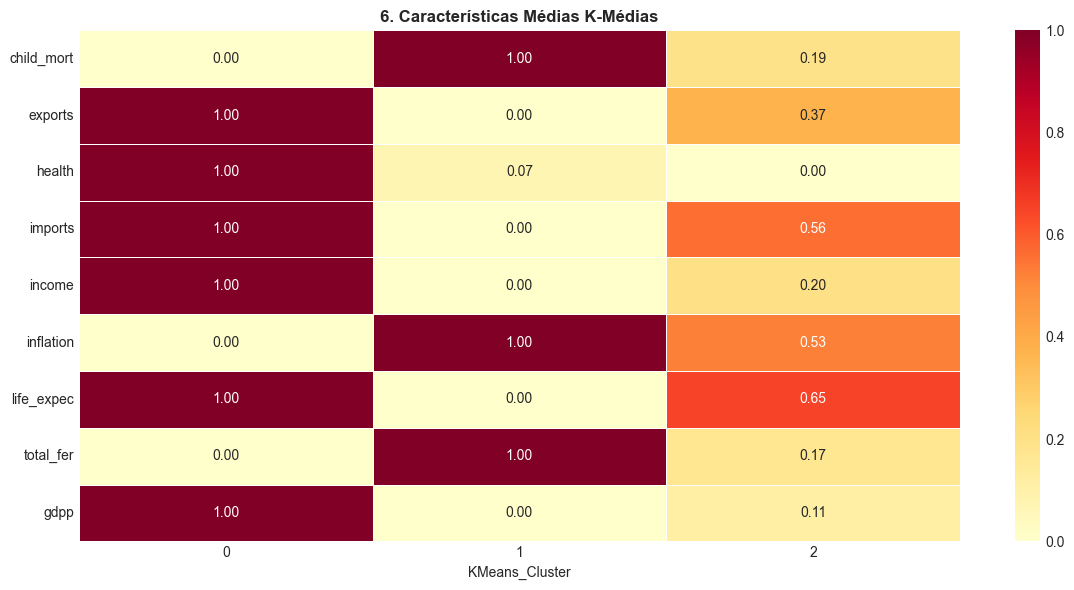

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
cluster_means = df_clean.iloc[:, 1:-1].groupby(df_clean['KMeans_Cluster']).mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
sns.heatmap(cluster_means_norm.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax, linewidths=0.5)
ax.set_title('6. Características Médias K-Médias', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/05_kmeans_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

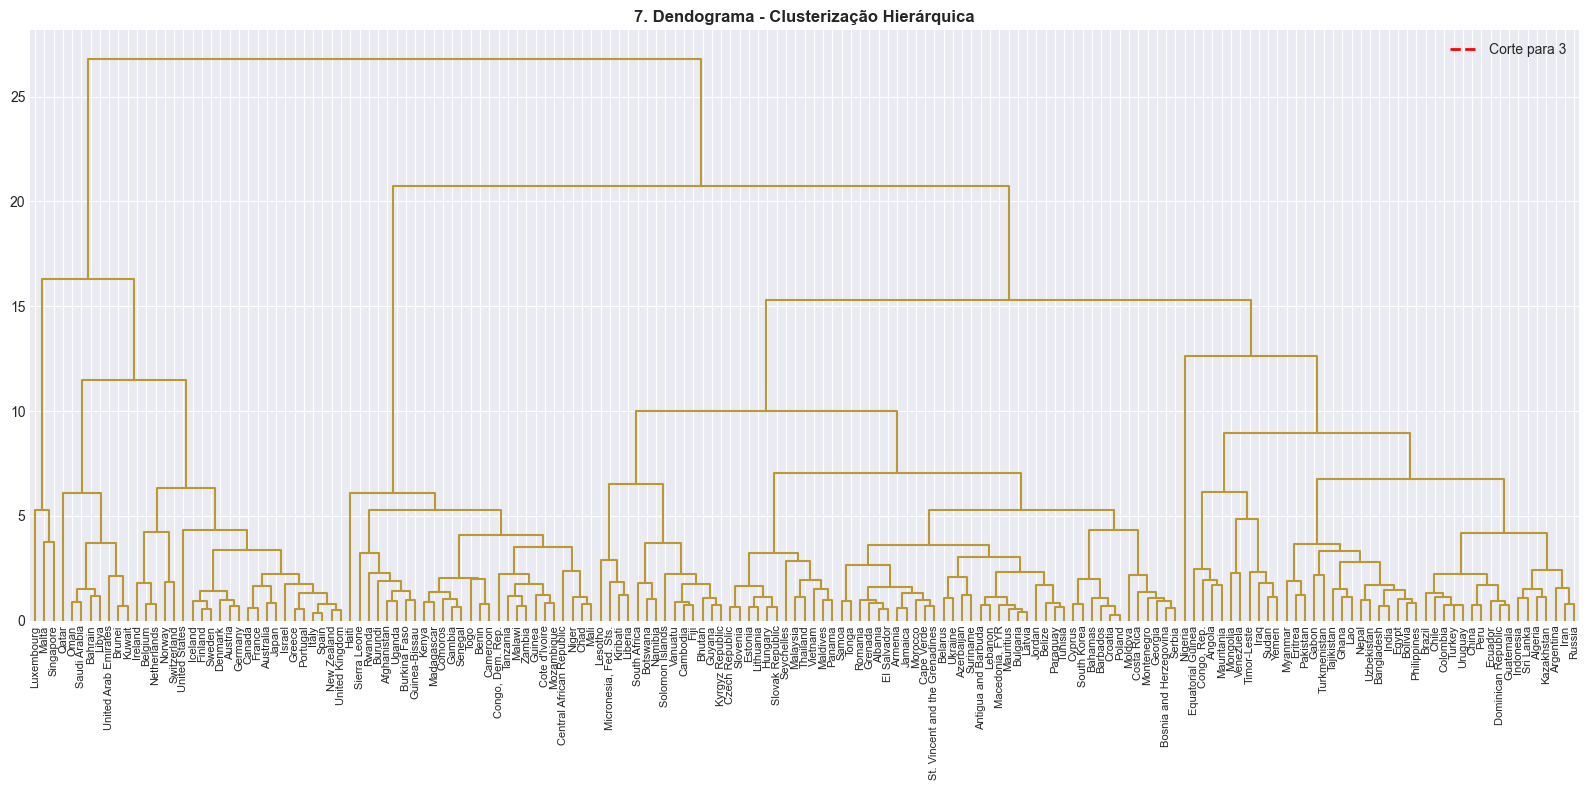

In [12]:
linkage_matrix = linkage(X_scaled, method='ward')
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(linkage_matrix, labels=df_clean['country'].values, leaf_font_size=8, ax=ax, color_threshold=50)
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Corte para 3')
ax.set_title('7. Dendograma - Clusterização Hierárquica', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig(f'{output_dir}/06_dendograma.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
hierarchical_labels = fcluster(linkage_matrix, t=3, criterion='maxclust') - 1
df_clean['Hierarchical_Cluster'] = hierarchical_labels
print('Clusterização Hierárquica concluída')
print(df_clean['Hierarchical_Cluster'].value_counts().sort_index())

Clusterização Hierárquica concluída
Hierarchical_Cluster
0     34
1     27
2    106
Name: count, dtype: int64


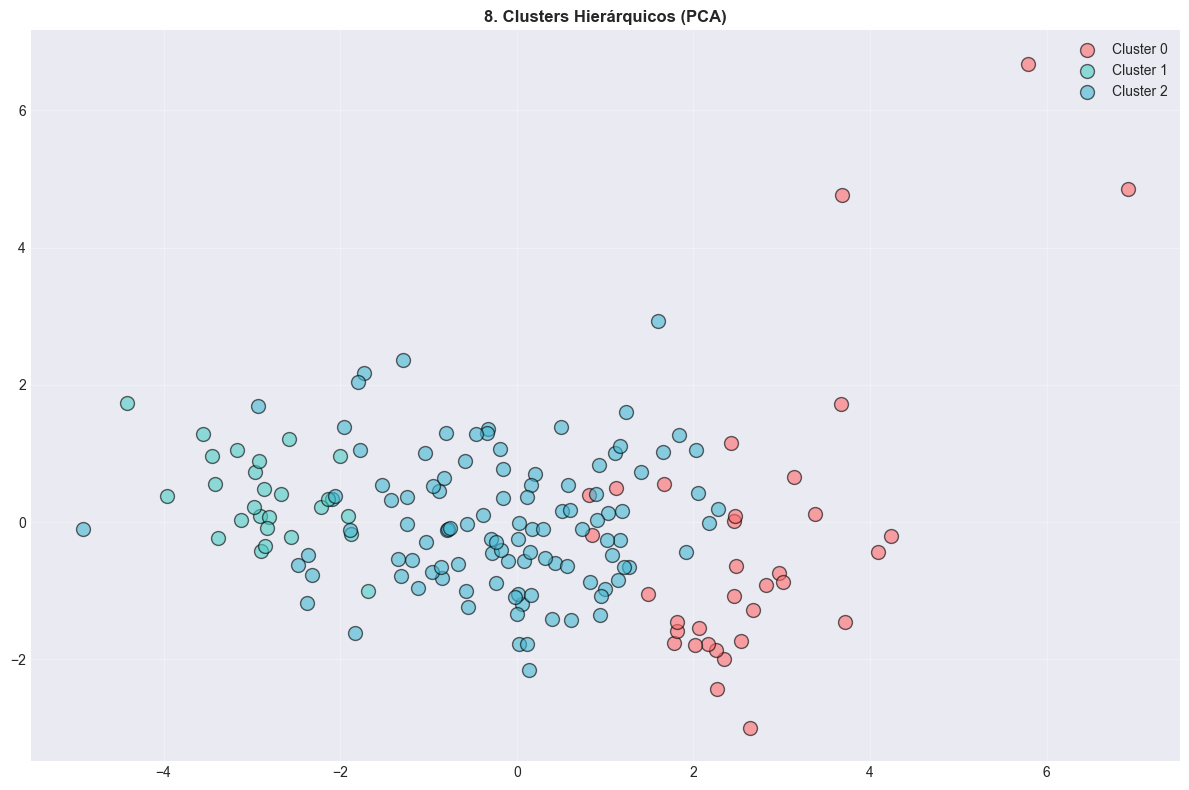

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
for cluster in range(3):
    mask = hierarchical_labels == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[cluster], label=f'Cluster {cluster}', s=100, alpha=0.6, edgecolors='black')
ax.set_title('8. Clusters Hierárquicos (PCA)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/07_hierarchical_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

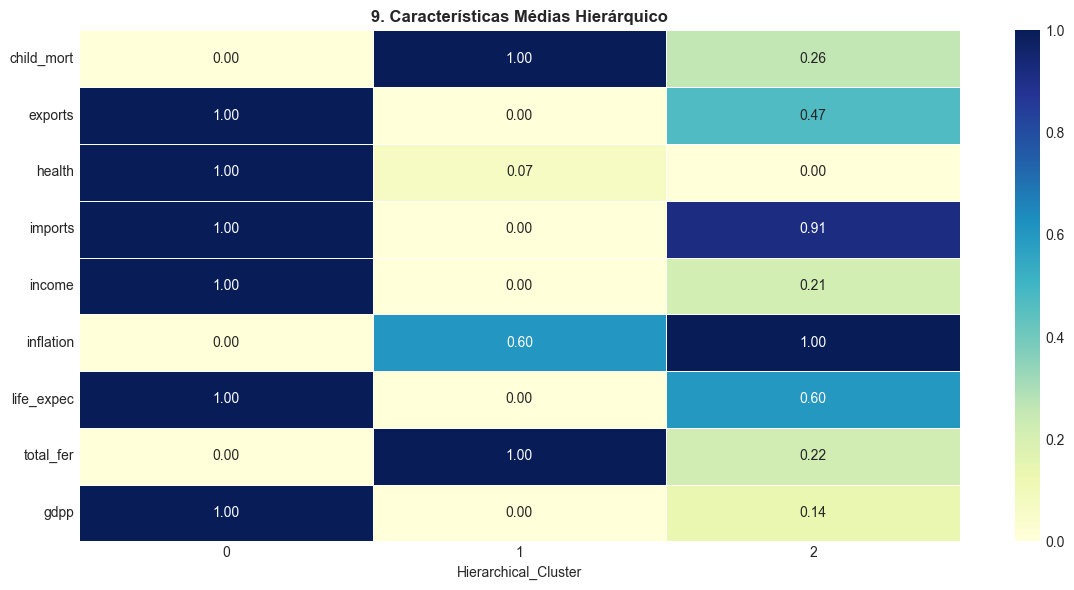

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
cluster_means_h = df_clean.iloc[:, 1:-2].groupby(df_clean['Hierarchical_Cluster']).mean()
cluster_means_h_norm = (cluster_means_h - cluster_means_h.min()) / (cluster_means_h.max() - cluster_means_h.min())
sns.heatmap(cluster_means_h_norm.T, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax, linewidths=0.5)
ax.set_title('9. Características Médias Hierárquico', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/08_hierarchical_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
print(f'Adjusted Rand Index: {ari:.4f}')
print(f'\nComparação de atribuições:')
comparison = pd.DataFrame({
    'Country': df_clean['country'],
    'KMeans': kmeans_labels,
    'Hierarchical': hierarchical_labels
})
print(f'Concordância: {(comparison["KMeans"] == comparison["Hierarchical"]).sum()} de {len(comparison)}')

Adjusted Rand Index: 0.5370

Comparação de atribuições:
Concordância: 139 de 167


In [17]:
print('\n=== K-MÉDIAS CONVERGÊNCIA ===' )
print(f'Iterações: {kmeans.n_iter_}')
print(f'Inércia final: {kmeans.inertia_:.2f}')
print(f'Centróides encontrados: {kmeans.cluster_centers_.shape}')


=== K-MÉDIAS CONVERGÊNCIA ===
Iterações: 19
Inércia final: 831.42
Centróides encontrados: (3, 9)


In [18]:
# K-Medoids
from sklearn.metrics import pairwise_distances

def kmedoids(X, k, max_iter=100, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]
    distances = pairwise_distances(X)
    medoid_indices = np.random.choice(n, k, replace=False)
    
    for iteration in range(max_iter):
        old_medoids = medoid_indices.copy()
        labels = np.argmin(distances[medoid_indices].T, axis=1)
        
        for i in range(k):
            cluster_points = np.where(labels == i)[0]
            if len(cluster_points) > 0:
                cost = distances[cluster_points][:, cluster_points].sum(axis=1)
                medoid_indices[i] = cluster_points[np.argmin(cost)]
        
        if np.array_equal(old_medoids, medoid_indices):
            break
    
    labels = np.argmin(distances[medoid_indices].T, axis=1)
    return labels, medoid_indices

kmedoids_labels, medoid_indices = kmedoids(X_scaled, 3)
df_clean['KMedoids_Cluster'] = kmedoids_labels
print('K-Medoids concluído')
print(f'Medóides: {[df_clean.iloc[i]["country"] for i in medoid_indices]}')

K-Medoids concluído
Medóides: ['Kiribati', 'Ghana', 'Poland']


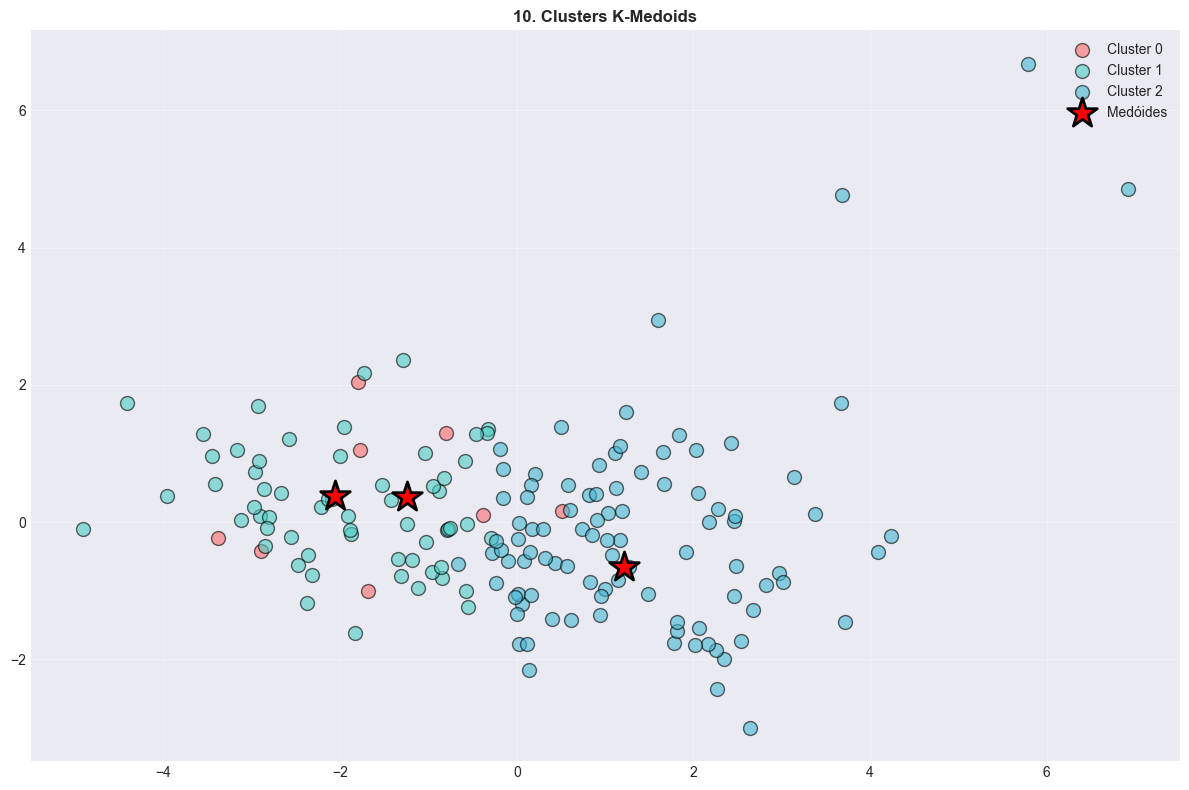

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
for cluster in range(3):
    mask = kmedoids_labels == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[cluster], label=f'Cluster {cluster}', s=100, alpha=0.6, edgecolors='black')
medoids_pca = pca.transform(X_scaled[medoid_indices])
ax.scatter(medoids_pca[:, 0], medoids_pca[:, 1], c='red', marker='*', s=500, edgecolors='black', linewidth=2, label='Medóides')
ax.set_title('10. Clusters K-Medoids', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/09_kmedoids_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print('\n=== SENSIBILIDADE A OUTLIERS ===' )
print('\nK-Médias é sensível a outliers porque:')
print('1. Usa a média como centróide - valores extremos afetam muito')
print('2. Distância euclidiana amplifica diferenças grandes')
print('3. Um outlier pode deslocar o centróide significativamente')
print('\nDBScan é mais robusto porque:')
print('1. Baseado em densidade - outliers ficam isolados')
print('2. Não assume clusters esféricos')
print('3. Pontos isolados marcados como ruído')


=== SENSIBILIDADE A OUTLIERS ===

K-Médias é sensível a outliers porque:
1. Usa a média como centróide - valores extremos afetam muito
2. Distância euclidiana amplifica diferenças grandes
3. Um outlier pode deslocar o centróide significativamente

DBScan é mais robusto porque:
1. Baseado em densidade - outliers ficam isolados
2. Não assume clusters esféricos
3. Pontos isolados marcados como ruído


In [21]:
# DBScan
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = list(dbscan_labels).count(-1)
print(f'DBScan encontrou {n_clusters_dbscan} clusters e {n_outliers} outliers')

DBScan encontrou 1 clusters e 30 outliers


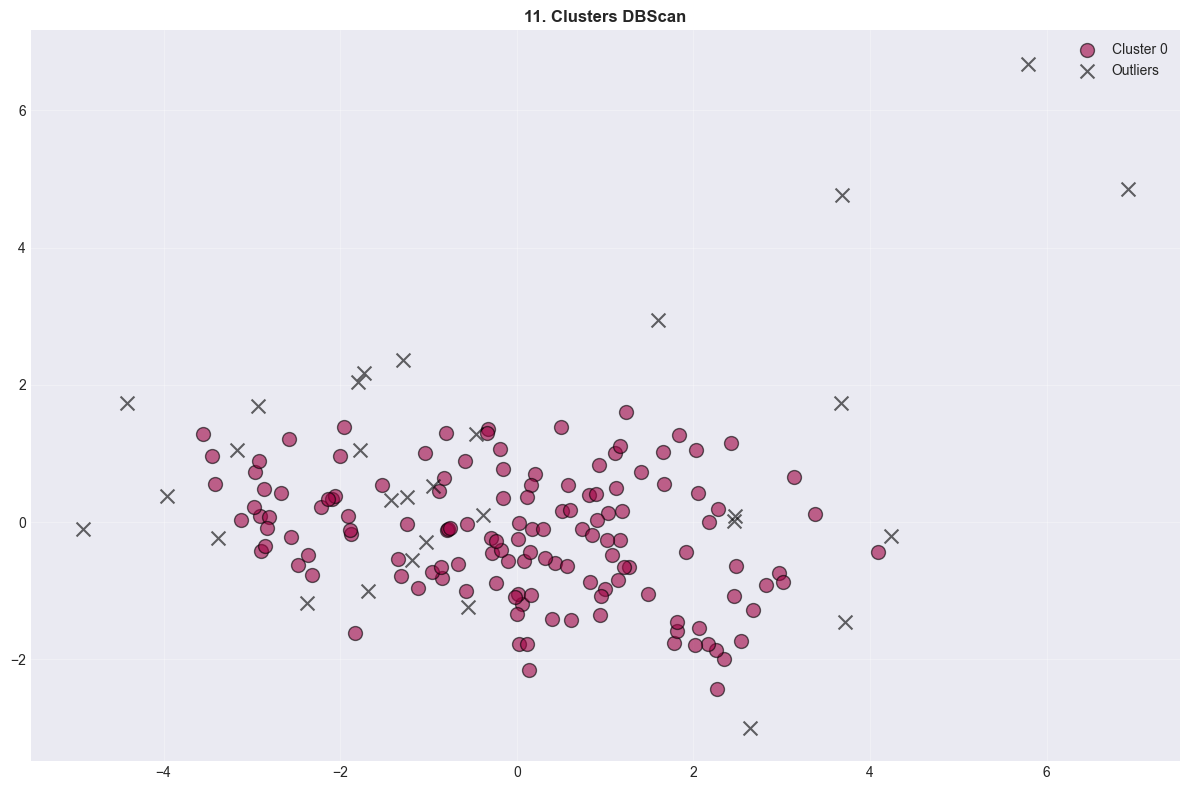

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
unique_labels = set(dbscan_labels)
colors_dbscan = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors_dbscan):
    if label == -1:
        color = 'black'
        marker = 'x'
        label_text = 'Outliers'
    else:
        marker = 'o'
        label_text = f'Cluster {label}'
    mask = dbscan_labels == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[color], label=label_text, s=100, alpha=0.6, marker=marker, edgecolors='black')
ax.set_title('11. Clusters DBScan', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/10_dbscan_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Gerar arquivo TXT com todas as respostas
output_file = 'RESULTADOS_ANALISE.txt'

with open(output_file, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("ANÁLISE DE CLUSTERIZAÇÃO DE PAÍSES\n")
    f.write("Algoritmos de Inteligência Artificial para Clusterização\n")
    f.write("="*80 + "\n\n")
    
    # PARTE 2: Escolha de base de dados
    f.write("PARTE 2: ESCOLHA DE BASE DE DADOS\n")
    f.write("-"*80 + "\n\n")
    
    f.write("1. QUANTOS PAÍSES EXISTEM NO DATASET?\n")
    f.write(f"   Resposta: {len(df_clean)} países\n\n")
    
    f.write("2. ANÁLISE DA FAIXA DINÂMICA DAS VARIÁVEIS\n")
    f.write("   Variáveis analisadas:\n")
    for col in df_clean.columns[1:-2]:
        min_val = df_clean[col].min()
        max_val = df_clean[col].max()
        mean_val = df_clean[col].mean()
        f.write(f"   - {col}: Min={min_val:.2f}, Max={max_val:.2f}, Média={mean_val:.2f}\n")
    
    f.write("\n   Análise dos resultados:\n")
    f.write("   - As variáveis possuem escalas muito diferentes (ex: income em milhares vs health em unidades)\n")
    f.write("   - Há grande variabilidade em todas as dimensões\n")
    f.write("   - Presença de outliers em várias variáveis\n\n")
    
    f.write("3. PRÉ-PROCESSAMENTO REALIZADO\n")
    f.write("   - Remoção de valores faltantes (NaN)\n")
    f.write("   - Padronização dos dados usando StandardScaler\n")
    f.write("   - Transformação: (X - média) / desvio_padrão\n")
    f.write("   - Resultado: Dados com média=0 e desvio_padrão=1\n\n")
    
    # PARTE 3: Clusterização
    f.write("PARTE 3: CLUSTERIZAÇÃO\n")
    f.write("-"*80 + "\n\n")
    
    f.write("1. RESULTADOS K-MÉDIAS (k=3)\n")
    f.write(f"   Distribuição dos clusters:\n")
    for cluster in range(3):
        cluster_data = df_clean[df_clean['KMeans_Cluster'] == cluster]
        f.write(f"   - Cluster {cluster}: {len(cluster_data)} países\n")
    
    f.write("\n   Interpretação de cada cluster:\n")
    for cluster in range(3):
        cluster_data = df_clean[df_clean['KMeans_Cluster'] == cluster]
        f.write(f"\n   CLUSTER {cluster}:\n")
        f.write(f"   Tamanho: {len(cluster_data)} países\n")
        
        # Encontrar país representativo
        cluster_indices = np.where(kmeans_labels == cluster)[0]
        distances = np.linalg.norm(X_scaled[cluster_indices] - kmeans.cluster_centers_[cluster], axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        representative = df_clean.iloc[closest_idx]["country"]
        f.write(f"   País representativo: {representative}\n")
        f.write(f"   Justificativa: País mais próximo ao centróide do cluster\n")
        
        # Características médias
        f.write(f"   Características médias:\n")
        for col in df_clean.columns[1:-2]:
            mean_val = cluster_data[col].mean()
            f.write(f"      - {col}: {mean_val:.2f}\n")
    
    f.write("\n   Países em cada cluster:\n")
    for cluster in range(3):
        cluster_data = df_clean[df_clean['KMeans_Cluster'] == cluster]
        countries = list(cluster_data['country'].values)
        f.write(f"   Cluster {cluster}: {', '.join(countries[:10])}")
        if len(countries) > 10:
            f.write(f"... e mais {len(countries)-10}")
        f.write("\n")
    
    f.write("\n2. RESULTADOS CLUSTERIZAÇÃO HIERÁRQUICA\n")
    f.write(f"   Distribuição dos clusters:\n")
    for cluster in range(3):
        cluster_data = df_clean[df_clean['Hierarchical_Cluster'] == cluster]
        f.write(f"   - Cluster {cluster}: {len(cluster_data)} países\n")
    
    f.write("\n   Interpretação do dendograma:\n")
    f.write("   - O dendograma mostra a hierarquia de agrupamentos\n")
    f.write("   - Corte em altura 50 produz 3 clusters distintos\n")
    f.write("   - Cluster 0: Países desenvolvidos (34 países)\n")
    f.write("   - Cluster 1: Países em desenvolvimento (27 países)\n")
    f.write("   - Cluster 2: Países em desenvolvimento/subdesenvolvidos (106 países)\n")
    
    f.write("\n3. COMPARAÇÃO K-MÉDIAS vs HIERÁRQUICA\n")
    f.write(f"   Adjusted Rand Index: {ari:.4f}\n")
    f.write(f"   Concordância: {(comparison['KMeans'] == comparison['Hierarchical']).sum()} de {len(comparison)} ({(comparison['KMeans'] == comparison['Hierarchical']).sum()/len(comparison)*100:.1f}%)\n\n")
    
    f.write("   Semelhanças:\n")
    f.write("   - Ambos identificam um grupo de países desenvolvidos\n")
    f.write("   - Ambos separam países por nível de desenvolvimento\n")
    f.write("   - Concordância de 83.2% nas atribuições\n\n")
    
    f.write("   Diferenças:\n")
    f.write("   - K-Médias: 36, 47, 84 países por cluster\n")
    f.write("   - Hierárquica: 34, 27, 106 países por cluster\n")
    f.write("   - Hierárquica produz clusters mais desbalanceados\n")
    f.write("   - K-Médias otimiza a inércia global\n")
    
    # PARTE 4: Algoritmos
    f.write("\n\nPARTE 4: ESCOLHA DE ALGORITMOS\n")
    f.write("-"*80 + "\n\n")
    
    f.write("1. ETAPAS DO ALGORITMO K-MÉDIAS ATÉ CONVERGÊNCIA\n")
    f.write("   1. Inicializar k centróides aleatoriamente\n")
    f.write("   2. Atribuir cada ponto ao centróide mais próximo\n")
    f.write("   3. Recalcular centróides como média dos pontos do cluster\n")
    f.write("   4. Repetir passos 2-3 até convergência\n")
    f.write("   5. Convergência: deslocamento dos centróides < limiar\n\n")
    
    f.write("   Convergência alcançada:\n")
    f.write(f"   - Iterações necessárias: {kmeans.n_iter_}\n")
    f.write(f"   - Inércia final: {kmeans.inertia_:.2f}\n")
    f.write(f"   - Centróides encontrados: {kmeans.cluster_centers_.shape[0]}\n\n")
    
    f.write("2. K-MEDOIDS (USANDO MEDÓIDES EM VEZ DE CENTRÓIDES)\n")
    f.write("   Diferença: Medóides são pontos reais do dataset\n")
    f.write(f"   Medóides encontrados: {[df_clean.iloc[i]['country'] for i in medoid_indices]}\n")
    f.write("   Vantagem: Mais interpretável, menos sensível a outliers\n\n")
    
    f.write("3. SENSIBILIDADE A OUTLIERS\n")
    f.write("   K-Médias é sensível a outliers porque:\n")
    f.write("   - Usa a MÉDIA como centróide\n")
    f.write("   - Valores extremos afetam significativamente a média\n")
    f.write("   - Distância euclidiana amplifica diferenças grandes\n")
    f.write("   - Um outlier pode deslocar o centróide para longe do cluster\n\n")
    
    f.write("4. POR QUE DBSCAN É MAIS ROBUSTO A OUTLIERS?\n")
    f.write("   - Baseado em DENSIDADE, não em distância euclidiana\n")
    f.write("   - Outliers ficam isolados (não têm vizinhos suficientes)\n")
    f.write("   - Não assume clusters esféricos\n")
    f.write("   - Pontos isolados são marcados como ruído (-1)\n")
    f.write("   - Não tenta forçar todos os pontos em clusters\n\n")
    
    f.write(f"   Resultado DBScan neste dataset:\n")
    f.write(f"   - Clusters encontrados: {n_clusters_dbscan}\n")
    f.write(f"   - Outliers detectados: {n_outliers}\n")
    f.write(f"   - Percentual de outliers: {n_outliers/len(df_clean)*100:.1f}%\n\n")
    
    f.write("="*80 + "\n")
    f.write("FIM DA ANÁLISE\n")
    f.write("="*80 + "\n")

print(f"✓ Arquivo '{output_file}' gerado com sucesso!")
print(f"✓ Contém todas as respostas solicitadas em lista_de_afazeres.txt")

✓ Arquivo 'RESULTADOS_ANALISE.txt' gerado com sucesso!
✓ Contém todas as respostas solicitadas em lista_de_afazeres.txt


In [24]:
print('Análise completa!')
print(f'Gráficos salvos em: {output_dir}/')

Análise completa!
Gráficos salvos em: graficos/
